
1. 모델 아키텍처 개선
- U-Net의 채널 수 증가 (64->128, 128->256, 256->512)
- Attention 메커니즘 추가
- Residual connections 추가
- 더 깊은 네트워크 구조

2. Loss Function 개선
- Reconstruction loss + Gradient loss + Frequency domain loss 조합
- 시계열 데이터의 특성을 반영한 커스텀 loss 설계
- 가중치 밸런싱 적용

3. 데이터 전처리
- RobustScaler 사용 (이상치 처리)
- 추가 특성 생성 (가속도/자이로 magnitude)
- 데이터 증강 기법 적용 (Time warping, Noise injection, Rotation)

4. DDPM 파라미터 최적화
- noise_steps 증가 (1000 -> 2000)
- beta 값 범위 조정 (start: 1e-6, end: 1e-2)
- 노이즈 스케일 미세 조정 (0.8 -> 0.5)

5. 학습 전략
- 배치 사이즈 감소 (64 -> 32)
- 에폭 수 증가 (200 -> 500)
- 학습률 미세 조정 (1e-4 -> 5e-5)
- Cosine Annealing with Warm Restarts 적용

6. 평가 방법 개선
- F2-score 기반 임계값 최적화
- Precision-Recall curve 활용
- False Negative 최소화에 중점


----- 

- 파라미터 변경 : 성능 향상 없음
- 파라미터 변경 + robust scaler + 특징 추가 (각속도) : 별로임

In [55]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

In [57]:
'''
        Each file contains nine columns and a different number of rows depending on the test length.
        
        1st column is the acceleration data in the X axis measured by the sensor ADXL345.
        2nd column is the acceleration data in the Y axis measured by the sensor ADXL345.
        3rd column is the acceleration data in the Z axis measured by the sensor ADXL345.

        4th column is the rotation data in the X axis measured by the sensor ITG3200.
        5th column is the rotation data in the Y axis measured by the sensor ITG3200.
        6th column is the rotation data in the Z axis measured by the sensor ITG3200.

        7th column is the acceleration data in the X axis measured by the sensor MMA8451Q.
        8th column is the acceleration data in the Y axis measured by the sensor MMA8451Q.
        9th column is the acceleration data in the Z axis measured by the sensor MMA8451Q.
        
        Data are in bits with the following characteristics:

        ADXL345:
        Resolution: 13 bits
        Range: +-16g

        ITG3200
        Resolution: 16 bits
        Range: +-2000°/s

        MMA8451Q:
        Resolution: 14 bits
        Range: +-8g
'''

'\n        Each file contains nine columns and a different number of rows depending on the test length.\n        \n        1st column is the acceleration data in the X axis measured by the sensor ADXL345.\n        2nd column is the acceleration data in the Y axis measured by the sensor ADXL345.\n        3rd column is the acceleration data in the Z axis measured by the sensor ADXL345.\n\n        4th column is the rotation data in the X axis measured by the sensor ITG3200.\n        5th column is the rotation data in the Y axis measured by the sensor ITG3200.\n        6th column is the rotation data in the Z axis measured by the sensor ITG3200.\n\n        7th column is the acceleration data in the X axis measured by the sensor MMA8451Q.\n        8th column is the acceleration data in the Y axis measured by the sensor MMA8451Q.\n        9th column is the acceleration data in the Z axis measured by the sensor MMA8451Q.\n        \n        Data are in bits with the following characteristics:\

In [58]:
datapath = "./data/SisFall.csv"

df = pd.read_csv(datapath, index_col=0)
df.head(10)

,ADXL_x,ADXL_y,ADXL_z,ITG_x,ITG_y,ITG_z,MMA_x,MMA_y,MMA_z,subject,activity,trial
NaN,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,SA01,D01,R01
0.0,17.0,-179.0,-99.0,-18.0,-504.0,-352.0,76.0,-697.0,-279.0,SA01,D01,R01
1.0,15.0,-174.0,-90.0,-53.0,-568.0,-306.0,48.0,-675.0,-254.0,SA01,D01,R01
2.0,1.0,-176.0,-81.0,-84.0,-613.0,-271.0,-2.0,-668.0,-221.0,SA01,D01,R01
3.0,-10.0,-180.0,-77.0,-104.0,-647.0,-227.0,-34.0,-697.0,-175.0,SA01,D01,R01
4.0,-21.0,-191.0,-63.0,-128.0,-675.0,-191.0,-74.0,-741.0,-133.0,SA01,D01,R01
5.0,-37.0,-225.0,-59.0,-146.0,-700.0,-159.0,-110.0,-840.0,-103.0,SA01,D01,R01
6.0,-36.0,-243.0,-46.0,-166.0,-722.0,-131.0,-147.0,-948.0,-75.0,SA01,D01,R01
7.0,-44.0,-271.0,-38.0,-190.0,-738.0,-107.0,-171.0,-1073.0,-38.0,SA01,D01,R01
8.0,-51.0,-312.0,-33.0,-210.0,-752.0,-90.0,-200.0,-1191.0,3.0,SA01,D01,R01


In [59]:
print (df.columns)
print (set(df['subject']))
features = df.copy()

dnum = 200
fnum = 365

Index(['ADXL_x', 'ADXL_y', 'ADXL_z', 'ITG_x', 'ITG_y', 'ITG_z', 'MMA_x',
       'MMA_y', 'MMA_z', 'subject', 'activity', 'trial'],
      dtype='object')
{'SA13', 'SA17', 'SA08', 'SA20', 'SE03', 'SA07', 'SA10', 'SE02', 'SA01', 'SA12', 'SA15', 'SA23', 'SE11', 'SE15', 'SA03', 'SE06', 'SE01', 'SE09', 'SE13', 'SE04', 'SE05', 'SE07', 'SA05', 'SE10', 'SA18', 'SA19', 'SA02', 'SE08', 'SA21', 'SA22', 'SA09', 'SE14', 'SE12', 'SA06', 'SA16', 'SA11', 'SA04', 'SA14'}


In [60]:
D01 = features[features['activity']=='D01'].head(dnum).copy()
D02 = features[features['activity']=='D02'].head(dnum).copy()
D03 = features[features['activity']=='D03'].head(dnum).copy()
D04 = features[features['activity']=='D04'].head(dnum).copy()
D05 = features[features['activity']=='D05'].head(dnum).copy()
D06 = features[features['activity']=='D06'].head(dnum).copy()
D07 = features[features['activity']=='D07'].head(dnum).copy()
D08 = features[features['activity']=='D08'].head(dnum).copy()
D09 = features[features['activity']=='D09'].head(dnum).copy()
D10 = features[features['activity']=='D10'].head(dnum).copy()
D11 = features[features['activity']=='D11'].head(dnum).copy()
D12 = features[features['activity']=='D12'].head(dnum).copy()
D13 = features[features['activity']=='D13'].head(dnum).copy()
D14 = features[features['activity']=='D14'].head(dnum).copy()
D15 = features[features['activity']=='D15'].head(dnum).copy()
D16 = features[features['activity']=='D16'].head(dnum).copy()
D17 = features[features['activity']=='D17'].head(dnum).copy()
D18 = features[features['activity']=='D18'].head(dnum).copy()
D19 = features[features['activity']=='D19'].head(dnum).copy()

In [61]:
F01 = features[features['activity']=='F01'].head(fnum).copy()
F02 = features[features['activity']=='F02'].head(fnum).copy()
F03 = features[features['activity']=='F03'].head(fnum).copy()
F04 = features[features['activity']=='F04'].head(fnum).copy()
F05 = features[features['activity']=='F05'].head(fnum).copy()
F06 = features[features['activity']=='F06'].head(fnum).copy()
F07 = features[features['activity']=='F07'].head(fnum).copy()
F08 = features[features['activity']=='F08'].head(fnum).copy()
F09 = features[features['activity']=='F09'].head(fnum).copy()
F10 = features[features['activity']=='F10'].head(fnum).copy()
F11 = features[features['activity']=='F11'].head(fnum).copy()
F12 = features[features['activity']=='F12'].head(fnum).copy()
F13 = features[features['activity']=='F13'].head(fnum).copy()
F14 = features[features['activity']=='F14'].head(fnum).copy()
F15 = features[features['activity']=='F15'].head(fnum).copy()

In [62]:
df = pd.DataFrame()
df = pd.concat([df, F01, F02, F03, F04, F05, F06, F07, F08, F09, F10, F11, F12, F13, F14, F15])
df = pd.concat([df, D01, D02, D03, D04, D05, D06, D07, D08, D09, D10, D11, D15, D16, D17, D18, D19])

In [63]:
df['activity'].value_counts()

activity
F01    365
F09    365
F02    365
F15    365
F14    365
F13    365
F11    365
F10    365
F12    365
F08    365
F07    365
F06    365
F05    365
F04    365
F03    365
D09    200
D18    200
D17    200
D16    200
D15    200
D11    200
D10    200
D01    200
D08    200
D07    200
D06    200
D05    200
D04    200
D03    200
D02    200
D19    200
Name: count, dtype: int64

In [64]:
features = df.copy()

In [65]:
features = features.replace({'activity':'D01'},0)
features = features.replace({'activity':'D01'},0)
features = features.replace({'activity':'D02'},0)
features = features.replace({'activity':'D03'},0)
features = features.replace({'activity':'D04'},0)
features = features.replace({'activity':'D05'},0)
features = features.replace({'activity':'D06'},0)
features = features.replace({'activity':'D07'},0)
features = features.replace({'activity':'D08'},0)
features = features.replace({'activity':'D09'},0)
features = features.replace({'activity':'D10'},0)
features = features.replace({'activity':'D11'},0)
features = features.replace({'activity':'D12'},0)
features = features.replace({'activity':'D13'},0)
features = features.replace({'activity':'D14'},0)
features = features.replace({'activity':'D15'},0)
features = features.replace({'activity':'D16'},0)
features = features.replace({'activity':'D17'},0)
features = features.replace({'activity':'D18'},0)
features = features.replace({'activity':'D19'},0)
features = features.replace({'activity':'F01'},1)
features = features.replace({'activity':'F02'},1)
features = features.replace({'activity':'F03'},1)
features = features.replace({'activity':'F04'},1)
features = features.replace({'activity':'F05'},1)
features = features.replace({'activity':'F06'},1)
features = features.replace({'activity':'F07'},1)
features = features.replace({'activity':'F08'},1)
features = features.replace({'activity':'F09'},1)
features = features.replace({'activity':'F10'},1)
features = features.replace({'activity':'F11'},1)
features = features.replace({'activity':'F12'},1)
features = features.replace({'activity':'F13'},1)
features = features.replace({'activity':'F14'},1)
features = features.replace({'activity':'F15'},1)
features = features.replace({'activity':'F15'},1)

/var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_55637/4220643108.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features = features.replace({'activity':'F15'},1)


In [66]:
features['activity'].value_counts()

activity
1    5475
0    3200
Name: count, dtype: int64

In [67]:
features

,ADXL_x,ADXL_y,ADXL_z,ITG_x,ITG_y,ITG_z,MMA_x,MMA_y,MMA_z,subject,activity,trial
NaN,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,SA01,1,R01
0.0,-9.0,-257.0,-25.0,84.0,247.0,27.0,-120.0,-987.0,63.0,SA01,1,R01
1.0,-3.0,-263.0,-23.0,99.0,258.0,35.0,-110.0,-1016.0,68.0,SA01,1,R01
2.0,-1.0,-270.0,-22.0,114.0,272.0,45.0,-94.0,-1037.0,69.0,SA01,1,R01
3.0,1.0,-277.0,-24.0,127.0,286.0,57.0,-81.0,-1062.0,69.0,SA01,1,R01
...,...,...,...,...,...,...,...,...,...,...,...,...
194.0,4.0,-259.0,-21.0,-56.0,2.0,-5.0,18.0,-1008.0,35.0,SA01,0,R01
195.0,9.0,-261.0,-27.0,-59.0,2.0,-5.0,23.0,-1014.0,35.0,SA01,0,R01
196.0,4.0,-261.0,-25.0,-62.0,3.0,-5.0,20.0,-1011.0,33.0,SA01,0,R01
197.0,4.0,-262.0,-21.0,-65.0,3.0,-4.0,18.0,-1009.0,36.0,SA01,0,R01


In [68]:
print (set(features['subject']))

{'SA01'}


In [69]:
features = features[[ft for ft in features.columns if ft not in ['subject', 'trial']]]
print(features.columns)

Index(['ADXL_x', 'ADXL_y', 'ADXL_z', 'ITG_x', 'ITG_y', 'ITG_z', 'MMA_x',
       'MMA_y', 'MMA_z', 'activity'],
      dtype='object')


In [103]:
from sklearn.preprocessing import RobustScaler

# activity 컬럼 따로 저장하고 인덱스 리셋
activity = features['activity'].copy().reset_index(drop=True)

# activity 제외한 feature들만 선택하고 인덱스 리셋
feature_columns = [col for col in features.columns if col != 'activity']
features_scaled = features[feature_columns].copy().reset_index(drop=True)

# RobustScaler 적용
scaler = RobustScaler()
features_scaled = pd.DataFrame(
    scaler.fit_transform(features_scaled),
    columns=feature_columns
)

# magnitude 특성 추가
features_scaled['ADXL_magnitude'] = np.sqrt(
    features_scaled['ADXL_x']**2 + 
    features_scaled['ADXL_y']**2 + 
    features_scaled['ADXL_z']**2
)
features_scaled['MMA_magnitude'] = np.sqrt(
    features_scaled['MMA_x']**2 + 
    features_scaled['MMA_y']**2 + 
    features_scaled['MMA_z']**2
)
features_scaled['ITG_magnitude'] = np.sqrt(
    features_scaled['ITG_x']**2 + 
    features_scaled['ITG_y']**2 + 
    features_scaled['ITG_z']**2
)

# activity를 마지막 열로 추가
features_scaled['activity'] = activity

# 확인
print("activity column is at:", features_scaled.columns[-1])
print("All columns:", features_scaled.columns.tolist())

activity column is at: activity
All columns: ['ADXL_x', 'ADXL_y', 'ADXL_z', 'ITG_x', 'ITG_y', 'ITG_z', 'MMA_x', 'MMA_y', 'MMA_z', 'ADXL_magnitude', 'MMA_magnitude', 'ITG_magnitude', 'activity']


In [104]:
adl_count = features_scaled['activity'].value_counts()[0]
fall_count = features_scaled['activity'].value_counts()[1]

adl_mask = features_scaled['activity'] == 0
adl_data = features_scaled[adl_mask]
adl1 = adl_data.iloc[:int(adl_count * 0.6)]
adl2 = adl_data.iloc[int(adl_count * 0.6):]

fall_mask = features_scaled['activity'] == 1
fall_data = features_scaled[fall_mask]
fall1 = fall_data.iloc[:int(fall_count * 0.6)]
fall2 = fall_data.iloc[int(fall_count * 0.6):]

print(adl1.shape, adl2.shape, fall1.shape, fall2.shape)

(1920, 13) (1280, 13) (3285, 13) (2190, 13)


In [105]:
def split_sequences(sequences, n_steps):
    X, y = [], []
    for i in range(len(sequences) - n_steps + 1):
        end_ix = i + n_steps
        
        seq_x = sequences.iloc[i:end_ix].iloc[:, :-1] 
        seq_y = sequences.iloc[end_ix-1].iloc[-1]     
        
        X.append(seq_x.values)  
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [106]:
WINDOW_LENGTH = 20
train_data, train_labels = split_sequences(adl1, WINDOW_LENGTH)
test_data, test_labels = split_sequences(pd.concat([adl2, fall2]), WINDOW_LENGTH)
print (f"after : {train_data.shape}, {test_data.shape}")
print (train_labels.shape, test_labels.shape)

after : (1901, 20, 12), (3451, 20, 12)
(1901,) (3451,)


----

In [107]:
BATCH_SIZE = 32  # 64에서 변경
EPOCHS = 200     # 200에서 변경
INITIAL_LEARNING_RATE = 5e-5  # 1e-4에서 변경
DECAY_STEPS = 2000   # 1000에서 변경
DECAY_RATE = 0.95    # 0.98에서 변경
WINDOW_LENGTH = 20   
device = "cpu"

In [108]:
class SisFallDataset(Dataset):
    def __init__(self, data):
        self.data = torch.FloatTensor(data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [109]:
'''
Input:      (20, 9)     # [window_length, num_sensors]
Level 1:    (10, 8)     # spatial ↓, channels ↑
Level 2:    (5, 16)     # spatial ↓, channels ↑
Bottleneck: (5, 32)     # bottleneck features
Level 2:    (10, 16)    # spatial ↑, channels ↓
Level 1:    (20, 8)     # spatial ↑, channels ↓
Output:     (20, 9)     # reconstruction
'''

'\nInput:      (20, 9)     # [window_length, num_sensors]\nLevel 1:    (10, 8)     # spatial ↓, channels ↑\nLevel 2:    (5, 16)     # spatial ↓, channels ↑\nBottleneck: (5, 32)     # bottleneck features\nLevel 2:    (10, 16)    # spatial ↑, channels ↓\nLevel 1:    (20, 8)     # spatial ↑, channels ↓\nOutput:     (20, 9)     # reconstruction\n'

In [110]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        return self.conv(x)

In [111]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding='same'),  # padding='same'로 변경
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding='same'),  # padding='same'로 변경
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        return self.conv(x)

class UNet1D(nn.Module):
    def __init__(self, 
                 in_channels=12,  # 9
                 time_dim=256):
        super(UNet1D, self).__init__()
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
            nn.GELU()
        )
        
        # Encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)
        
        # Time feature projection
        self.time_to_features1 = nn.Linear(time_dim, 64)
        self.time_to_features2 = nn.Linear(time_dim, 128)
        self.time_to_features3 = nn.Linear(time_dim, 256)
        self.time_to_bottleneck = nn.Linear(time_dim, 512)
        
        # Decoder with precise size matching
        self.upconv3 = nn.ConvTranspose1d(512, 256, kernel_size=2, stride=2, padding=0)
        self.dec3 = DoubleConv(512, 256)  # 512 = 256(upconv) + 256(skip)
        
        self.upconv2 = nn.ConvTranspose1d(256, 128, kernel_size=2, stride=2, padding=0)
        self.dec2 = DoubleConv(256, 128)  # 256 = 128(upconv) + 128(skip)
        
        self.upconv1 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2, padding=0)
        self.dec1 = DoubleConv(128, 64)   # 128 = 64(upconv) + 64(skip)
        
        self.final_conv = nn.Conv1d(64, in_channels, kernel_size=1)
        
        self.dropout = nn.Dropout(0.1)
        
    def calculate_padding(self, x_size, target_size):
        """Helper function to calculate padding needed"""
        diff = target_size - x_size
        return diff // 2, diff - diff // 2
        
    def forward(self, x, t):
        # Save input size for later
        input_size = x.shape[-1]
        
        # Time embedding
        t = t.float().unsqueeze(-1)
        t = self.time_mlp(t)
        
        # Encoder path with size tracking
        e1 = self.enc1(x)
        e1 = e1 + self.time_to_features1(t).unsqueeze(-1)
        e1_size = e1.shape[-1]
        p1 = self.pool1(e1)
        
        e2 = self.enc2(p1)
        e2 = e2 + self.time_to_features2(t).unsqueeze(-1)
        e2_size = e2.shape[-1]
        p2 = self.pool2(e2)
        
        e3 = self.enc3(p2)
        e3 = e3 + self.time_to_features3(t).unsqueeze(-1)
        e3_size = e3.shape[-1]
        p3 = self.pool3(e3)
        
        # Bottleneck
        b = self.bottleneck(p3)
        b = b + self.time_to_bottleneck(t).unsqueeze(-1)
        
        # Decoder path with precise size matching
        d3 = self.upconv3(b)
        # Pad d3 if necessary
        if d3.shape[-1] != e3.shape[-1]:
            pad_left, pad_right = self.calculate_padding(d3.shape[-1], e3.shape[-1])
            d3 = F.pad(d3, (pad_left, pad_right))
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.upconv2(d3)
        # Pad d2 if necessary
        if d2.shape[-1] != e2.shape[-1]:
            pad_left, pad_right = self.calculate_padding(d2.shape[-1], e2.shape[-1])
            d2 = F.pad(d2, (pad_left, pad_right))
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.upconv1(d2)
        # Pad d1 if necessary
        if d1.shape[-1] != e1.shape[-1]:
            pad_left, pad_right = self.calculate_padding(d1.shape[-1], e1.shape[-1])
            d1 = F.pad(d1, (pad_left, pad_right))
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        # Final convolution
        out = self.final_conv(d1)
        
        # Ensure output size matches input size
        if out.shape[-1] != input_size:
            pad_left, pad_right = self.calculate_padding(out.shape[-1], input_size)
            out = F.pad(out, (pad_left, pad_right))
            
        return out

In [112]:
class DiffusionUtils:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02):
        """
        Improved diffusion process with cosine schedule
        """
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        
        # Cosine schedule for better noise scaling
        self.beta = self.cosine_beta_schedule(noise_steps)
        self.alpha = 1 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        
    def cosine_beta_schedule(self, timesteps, s=0.008):
        """
        Cosine scheduling for variance of the diffusion process
        """
        steps = timesteps + 1
        x = torch.linspace(0, timesteps, steps)
        alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999)

    def noise_images(self, x, t):
        """
        Add noise to images according to diffusion schedule
        """
        # 데이터 정규화 추가
        x = (x - x.mean()) / (x.std() + 1e-8)
        
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None]
        ε = torch.randn_like(x)
        
        # 노이즈 스케일 조정 (약간 더 낮은 노이즈)
        ε = ε * 0.8
        
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * ε, ε
    
    def sample_timesteps(self, n):
        """
        Sample timesteps with emphasis on middle steps
        """
        # 중간 단계에 더 많은 가중치를 두는 샘플링
        t = torch.randint(low=1, high=self.noise_steps, size=(n,))
        weights = torch.exp(-0.00001 * (t.float() - self.noise_steps/2)**2)
        t = torch.multinomial(weights, n)
        return t
        
    def sample(self, model, n, device, window_length=20, channels=9):
        """
        Sampling from the learned distribution
        """
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, channels, window_length)).to(device)
            for i in reversed(range(1, self.noise_steps)):
                t = (torch.ones(n) * i).long().to(device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None]
                beta = self.beta[t][:, None, None]
                
                if i > 1:
                    noise = torch.randn_like(x) * 0.8  # 노이즈 스케일 조정
                else:
                    noise = torch.zeros_like(x)
                    
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        return x

In [113]:
def train_model(model, train_loader, diffusion, optimizer, scheduler, num_epochs, device):
    model.train()
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        train_loss = 0
        n_batches = len(train_loader)
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            batch = batch.to(device)
            batch = batch.permute(0, 2, 1)  # (batch_size, channels, window_length)
            
            optimizer.zero_grad()
            
            # 데이터 정규화 추가
            batch = (batch - batch.mean()) / (batch.std() + 1e-8)
            
            t = diffusion.sample_timesteps(batch.shape[0]).to(device)
            x_noisy, noise = diffusion.noise_images(batch, t)
            
            # Gradient clipping 추가
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            predicted_noise = model(x_noisy, t)
            
            # Loss 계산 방식 수정
            loss = F.smooth_l1_loss(predicted_noise, noise)  # MSE 대신 Smooth L1 Loss 사용
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # 학습 상태 출력 개선
            if train_loss / (n_batches) < best_loss:
                best_loss = train_loss / (n_batches)
                torch.save(model.state_dict(), 'best_model.pth')
        
        avg_loss = train_loss / n_batches
        scheduler.step()
        
        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} (Best: {best_loss:.4f})')

In [114]:
model = UNet1D().to(device)
diffusion = DiffusionUtils()
optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LEARNING_RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

train_dataset = SisFallDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

train_model(model, train_loader, diffusion, optimizer, scheduler, EPOCHS, device)

Epoch 1/200: 100%|██████████████████████████████| 60/60 [00:04<00:00, 13.67it/s]


Epoch 1/200 - Loss: 0.3346 (Best: 0.0060)


Epoch 2/200: 100%|██████████████████████████████| 60/60 [00:03<00:00, 15.21it/s]


Epoch 2/200 - Loss: 0.3164 (Best: 0.0053)


Epoch 3/200: 100%|██████████████████████████████| 60/60 [00:04<00:00, 14.26it/s]


Epoch 3/200 - Loss: 0.3107 (Best: 0.0053)


Epoch 4/200: 100%|██████████████████████████████| 60/60 [00:03<00:00, 16.94it/s]


Epoch 4/200 - Loss: 0.3065 (Best: 0.0051)


Epoch 5/200: 100%|██████████████████████████████| 60/60 [00:03<00:00, 16.02it/s]


Epoch 5/200 - Loss: 0.3037 (Best: 0.0050)


Epoch 6/200: 100%|██████████████████████████████| 60/60 [00:05<00:00, 11.11it/s]


Epoch 6/200 - Loss: 0.3026 (Best: 0.0050)


Epoch 7/200: 100%|██████████████████████████████| 60/60 [00:03<00:00, 16.18it/s]


Epoch 7/200 - Loss: 0.3027 (Best: 0.0049)


Epoch 8/200: 100%|██████████████████████████████| 60/60 [00:03<00:00, 15.46it/s]


Epoch 8/200 - Loss: 0.2996 (Best: 0.0049)


Epoch 9/200: 100%|██████████████████████████████| 60/60 [00:04<00:00, 14.12it/s]


Epoch 9/200 - Loss: 0.3006 (Best: 0.0049)


Epoch 10/200: 100%|█████████████████████████████| 60/60 [00:04<00:00, 14.52it/s]


Epoch 10/200 - Loss: 0.2997 (Best: 0.0049)


Epoch 11/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.17it/s]


Epoch 11/200 - Loss: 0.2998 (Best: 0.0049)


Epoch 12/200: 100%|█████████████████████████████| 60/60 [00:04<00:00, 12.76it/s]


Epoch 12/200 - Loss: 0.2997 (Best: 0.0049)


Epoch 13/200: 100%|█████████████████████████████| 60/60 [00:06<00:00,  9.62it/s]


Epoch 13/200 - Loss: 0.2984 (Best: 0.0049)


Epoch 14/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.08it/s]


Epoch 14/200 - Loss: 0.2993 (Best: 0.0049)


Epoch 15/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 15.47it/s]


Epoch 15/200 - Loss: 0.2983 (Best: 0.0049)


Epoch 16/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 15.25it/s]


Epoch 16/200 - Loss: 0.2995 (Best: 0.0049)


Epoch 17/200: 100%|█████████████████████████████| 60/60 [00:04<00:00, 12.67it/s]


Epoch 17/200 - Loss: 0.2980 (Best: 0.0049)


Epoch 18/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.79it/s]


Epoch 18/200 - Loss: 0.2978 (Best: 0.0049)


Epoch 19/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 15.40it/s]


Epoch 19/200 - Loss: 0.2980 (Best: 0.0049)


Epoch 20/200: 100%|█████████████████████████████| 60/60 [00:04<00:00, 14.66it/s]


Epoch 20/200 - Loss: 0.2977 (Best: 0.0049)


Epoch 21/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 15.32it/s]


Epoch 21/200 - Loss: 0.2972 (Best: 0.0049)


Epoch 22/200: 100%|█████████████████████████████| 60/60 [00:04<00:00, 13.85it/s]


Epoch 22/200 - Loss: 0.2964 (Best: 0.0049)


Epoch 23/200: 100%|█████████████████████████████| 60/60 [00:04<00:00, 13.47it/s]


Epoch 23/200 - Loss: 0.2983 (Best: 0.0049)


Epoch 24/200: 100%|█████████████████████████████| 60/60 [00:04<00:00, 12.62it/s]


Epoch 24/200 - Loss: 0.2973 (Best: 0.0049)


Epoch 25/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.86it/s]


Epoch 25/200 - Loss: 0.2961 (Best: 0.0049)


Epoch 26/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.96it/s]


Epoch 26/200 - Loss: 0.2962 (Best: 0.0049)


Epoch 27/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.81it/s]


Epoch 27/200 - Loss: 0.2962 (Best: 0.0049)


Epoch 28/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.59it/s]


Epoch 28/200 - Loss: 0.2968 (Best: 0.0048)


Epoch 29/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.93it/s]


Epoch 29/200 - Loss: 0.2953 (Best: 0.0048)


Epoch 30/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.42it/s]


Epoch 30/200 - Loss: 0.2963 (Best: 0.0048)


Epoch 31/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.11it/s]


Epoch 31/200 - Loss: 0.2955 (Best: 0.0048)


Epoch 32/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.07it/s]


Epoch 32/200 - Loss: 0.2946 (Best: 0.0047)


Epoch 33/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.96it/s]


Epoch 33/200 - Loss: 0.2942 (Best: 0.0047)


Epoch 34/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.11it/s]


Epoch 34/200 - Loss: 0.2938 (Best: 0.0047)


Epoch 35/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.27it/s]


Epoch 35/200 - Loss: 0.2940 (Best: 0.0047)


Epoch 36/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.03it/s]


Epoch 36/200 - Loss: 0.2930 (Best: 0.0047)


Epoch 37/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.31it/s]


Epoch 37/200 - Loss: 0.2928 (Best: 0.0047)


Epoch 38/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.14it/s]


Epoch 38/200 - Loss: 0.2923 (Best: 0.0047)


Epoch 39/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.42it/s]


Epoch 39/200 - Loss: 0.2925 (Best: 0.0047)


Epoch 40/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.18it/s]


Epoch 40/200 - Loss: 0.2911 (Best: 0.0047)


Epoch 41/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.18it/s]


Epoch 41/200 - Loss: 0.2920 (Best: 0.0047)


Epoch 42/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.98it/s]


Epoch 42/200 - Loss: 0.2917 (Best: 0.0047)


Epoch 43/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.19it/s]


Epoch 43/200 - Loss: 0.2898 (Best: 0.0047)


Epoch 44/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.85it/s]


Epoch 44/200 - Loss: 0.2898 (Best: 0.0047)


Epoch 45/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.98it/s]


Epoch 45/200 - Loss: 0.2892 (Best: 0.0047)


Epoch 46/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.01it/s]


Epoch 46/200 - Loss: 0.2888 (Best: 0.0047)


Epoch 47/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.56it/s]


Epoch 47/200 - Loss: 0.2880 (Best: 0.0047)


Epoch 48/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.78it/s]


Epoch 48/200 - Loss: 0.2874 (Best: 0.0047)


Epoch 49/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.92it/s]


Epoch 49/200 - Loss: 0.2870 (Best: 0.0047)


Epoch 50/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.93it/s]


Epoch 50/200 - Loss: 0.2868 (Best: 0.0047)


Epoch 51/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.25it/s]


Epoch 51/200 - Loss: 0.2858 (Best: 0.0047)


Epoch 52/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.07it/s]


Epoch 52/200 - Loss: 0.2856 (Best: 0.0047)


Epoch 53/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.85it/s]


Epoch 53/200 - Loss: 0.2856 (Best: 0.0047)


Epoch 54/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.21it/s]


Epoch 54/200 - Loss: 0.2845 (Best: 0.0047)


Epoch 55/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.27it/s]


Epoch 55/200 - Loss: 0.2844 (Best: 0.0046)


Epoch 56/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.06it/s]


Epoch 56/200 - Loss: 0.2842 (Best: 0.0046)


Epoch 57/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.30it/s]


Epoch 57/200 - Loss: 0.2831 (Best: 0.0046)


Epoch 58/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.09it/s]


Epoch 58/200 - Loss: 0.2825 (Best: 0.0046)


Epoch 59/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.09it/s]


Epoch 59/200 - Loss: 0.2819 (Best: 0.0046)


Epoch 60/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.14it/s]


Epoch 60/200 - Loss: 0.2821 (Best: 0.0046)


Epoch 61/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.09it/s]


Epoch 61/200 - Loss: 0.2813 (Best: 0.0046)


Epoch 62/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.21it/s]


Epoch 62/200 - Loss: 0.2802 (Best: 0.0046)


Epoch 63/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.64it/s]


Epoch 63/200 - Loss: 0.2808 (Best: 0.0046)


Epoch 64/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 15.83it/s]


Epoch 64/200 - Loss: 0.2792 (Best: 0.0046)


Epoch 65/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.15it/s]


Epoch 65/200 - Loss: 0.2792 (Best: 0.0046)


Epoch 66/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.43it/s]


Epoch 66/200 - Loss: 0.2793 (Best: 0.0046)


Epoch 67/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.77it/s]


Epoch 67/200 - Loss: 0.2785 (Best: 0.0046)


Epoch 68/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.06it/s]


Epoch 68/200 - Loss: 0.2783 (Best: 0.0046)


Epoch 69/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.80it/s]


Epoch 69/200 - Loss: 0.2780 (Best: 0.0046)


Epoch 70/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.16it/s]


Epoch 70/200 - Loss: 0.2755 (Best: 0.0046)


Epoch 71/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.32it/s]


Epoch 71/200 - Loss: 0.2767 (Best: 0.0046)


Epoch 72/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.03it/s]


Epoch 72/200 - Loss: 0.2758 (Best: 0.0046)


Epoch 73/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.88it/s]


Epoch 73/200 - Loss: 0.2743 (Best: 0.0046)


Epoch 74/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.60it/s]


Epoch 74/200 - Loss: 0.2755 (Best: 0.0046)


Epoch 75/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.14it/s]


Epoch 75/200 - Loss: 0.2743 (Best: 0.0046)


Epoch 76/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.89it/s]


Epoch 76/200 - Loss: 0.2741 (Best: 0.0046)


Epoch 77/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.12it/s]


Epoch 77/200 - Loss: 0.2740 (Best: 0.0046)


Epoch 78/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.00it/s]


Epoch 78/200 - Loss: 0.2737 (Best: 0.0046)


Epoch 79/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.07it/s]


Epoch 79/200 - Loss: 0.2722 (Best: 0.0046)


Epoch 80/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.15it/s]


Epoch 80/200 - Loss: 0.2728 (Best: 0.0046)


Epoch 81/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.33it/s]


Epoch 81/200 - Loss: 0.2718 (Best: 0.0045)


Epoch 82/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.50it/s]


Epoch 82/200 - Loss: 0.2715 (Best: 0.0045)


Epoch 83/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.84it/s]


Epoch 83/200 - Loss: 0.2710 (Best: 0.0045)


Epoch 84/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.25it/s]


Epoch 84/200 - Loss: 0.2718 (Best: 0.0045)


Epoch 85/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.14it/s]


Epoch 85/200 - Loss: 0.2715 (Best: 0.0045)


Epoch 86/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.91it/s]


Epoch 86/200 - Loss: 0.2701 (Best: 0.0045)


Epoch 87/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.24it/s]


Epoch 87/200 - Loss: 0.2702 (Best: 0.0045)


Epoch 88/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.18it/s]


Epoch 88/200 - Loss: 0.2696 (Best: 0.0045)


Epoch 89/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.17it/s]


Epoch 89/200 - Loss: 0.2695 (Best: 0.0045)


Epoch 90/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.97it/s]


Epoch 90/200 - Loss: 0.2697 (Best: 0.0045)


Epoch 91/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.09it/s]


Epoch 91/200 - Loss: 0.2675 (Best: 0.0045)


Epoch 92/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.95it/s]


Epoch 92/200 - Loss: 0.2683 (Best: 0.0045)


Epoch 93/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.95it/s]


Epoch 93/200 - Loss: 0.2679 (Best: 0.0045)


Epoch 94/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.09it/s]


Epoch 94/200 - Loss: 0.2675 (Best: 0.0045)


Epoch 95/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.59it/s]


Epoch 95/200 - Loss: 0.2678 (Best: 0.0045)


Epoch 96/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.94it/s]


Epoch 96/200 - Loss: 0.2665 (Best: 0.0045)


Epoch 97/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 17.06it/s]


Epoch 97/200 - Loss: 0.2666 (Best: 0.0045)


Epoch 98/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.52it/s]


Epoch 98/200 - Loss: 0.2671 (Best: 0.0044)


Epoch 99/200: 100%|█████████████████████████████| 60/60 [00:03<00:00, 16.79it/s]


Epoch 99/200 - Loss: 0.2651 (Best: 0.0044)


Epoch 100/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.81it/s]


Epoch 100/200 - Loss: 0.2661 (Best: 0.0044)


Epoch 101/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.94it/s]


Epoch 101/200 - Loss: 0.2641 (Best: 0.0044)


Epoch 102/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.89it/s]


Epoch 102/200 - Loss: 0.2645 (Best: 0.0044)


Epoch 103/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.26it/s]


Epoch 103/200 - Loss: 0.2639 (Best: 0.0044)


Epoch 104/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.02it/s]


Epoch 104/200 - Loss: 0.2643 (Best: 0.0044)


Epoch 105/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.13it/s]


Epoch 105/200 - Loss: 0.2637 (Best: 0.0043)


Epoch 106/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.00it/s]


Epoch 106/200 - Loss: 0.2644 (Best: 0.0043)


Epoch 107/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.98it/s]


Epoch 107/200 - Loss: 0.2651 (Best: 0.0043)


Epoch 108/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.16it/s]


Epoch 108/200 - Loss: 0.2631 (Best: 0.0043)


Epoch 109/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.93it/s]


Epoch 109/200 - Loss: 0.2635 (Best: 0.0043)


Epoch 110/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.81it/s]


Epoch 110/200 - Loss: 0.2622 (Best: 0.0043)


Epoch 111/200: 100%|████████████████████████████| 60/60 [00:04<00:00, 14.37it/s]


Epoch 111/200 - Loss: 0.2622 (Best: 0.0043)


Epoch 112/200: 100%|████████████████████████████| 60/60 [00:04<00:00, 13.09it/s]


Epoch 112/200 - Loss: 0.2621 (Best: 0.0043)


Epoch 113/200: 100%|████████████████████████████| 60/60 [00:04<00:00, 14.05it/s]


Epoch 113/200 - Loss: 0.2619 (Best: 0.0043)


Epoch 114/200: 100%|████████████████████████████| 60/60 [00:04<00:00, 13.11it/s]


Epoch 114/200 - Loss: 0.2615 (Best: 0.0043)


Epoch 115/200: 100%|████████████████████████████| 60/60 [00:04<00:00, 13.56it/s]


Epoch 115/200 - Loss: 0.2615 (Best: 0.0042)


Epoch 116/200: 100%|████████████████████████████| 60/60 [00:04<00:00, 13.55it/s]


Epoch 116/200 - Loss: 0.2615 (Best: 0.0042)


Epoch 117/200: 100%|████████████████████████████| 60/60 [00:04<00:00, 14.33it/s]


Epoch 117/200 - Loss: 0.2607 (Best: 0.0042)


Epoch 118/200: 100%|████████████████████████████| 60/60 [00:04<00:00, 14.48it/s]


Epoch 118/200 - Loss: 0.2617 (Best: 0.0042)


Epoch 119/200: 100%|████████████████████████████| 60/60 [00:04<00:00, 14.45it/s]


Epoch 119/200 - Loss: 0.2611 (Best: 0.0042)


Epoch 120/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 15.80it/s]


Epoch 120/200 - Loss: 0.2613 (Best: 0.0042)


Epoch 121/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.64it/s]


Epoch 121/200 - Loss: 0.2603 (Best: 0.0042)


Epoch 122/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.03it/s]


Epoch 122/200 - Loss: 0.2591 (Best: 0.0042)


Epoch 123/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.98it/s]


Epoch 123/200 - Loss: 0.2603 (Best: 0.0042)


Epoch 124/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.08it/s]


Epoch 124/200 - Loss: 0.2606 (Best: 0.0042)


Epoch 125/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.02it/s]


Epoch 125/200 - Loss: 0.2603 (Best: 0.0042)


Epoch 126/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.13it/s]


Epoch 126/200 - Loss: 0.2595 (Best: 0.0042)


Epoch 127/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.93it/s]


Epoch 127/200 - Loss: 0.2601 (Best: 0.0042)


Epoch 128/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.79it/s]


Epoch 128/200 - Loss: 0.2589 (Best: 0.0042)


Epoch 129/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.06it/s]


Epoch 129/200 - Loss: 0.2594 (Best: 0.0042)


Epoch 130/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.47it/s]


Epoch 130/200 - Loss: 0.2596 (Best: 0.0042)


Epoch 131/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.96it/s]


Epoch 131/200 - Loss: 0.2588 (Best: 0.0042)


Epoch 132/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.18it/s]


Epoch 132/200 - Loss: 0.2584 (Best: 0.0042)


Epoch 133/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.01it/s]


Epoch 133/200 - Loss: 0.2592 (Best: 0.0042)


Epoch 134/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.05it/s]


Epoch 134/200 - Loss: 0.2580 (Best: 0.0042)


Epoch 135/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.88it/s]


Epoch 135/200 - Loss: 0.2579 (Best: 0.0041)


Epoch 136/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.29it/s]


Epoch 136/200 - Loss: 0.2578 (Best: 0.0041)


Epoch 137/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.73it/s]


Epoch 137/200 - Loss: 0.2574 (Best: 0.0041)


Epoch 138/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.26it/s]


Epoch 138/200 - Loss: 0.2584 (Best: 0.0041)


Epoch 139/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.97it/s]


Epoch 139/200 - Loss: 0.2588 (Best: 0.0041)


Epoch 140/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.19it/s]


Epoch 140/200 - Loss: 0.2569 (Best: 0.0041)


Epoch 141/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.00it/s]


Epoch 141/200 - Loss: 0.2575 (Best: 0.0041)


Epoch 142/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.92it/s]


Epoch 142/200 - Loss: 0.2571 (Best: 0.0041)


Epoch 143/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.11it/s]


Epoch 143/200 - Loss: 0.2570 (Best: 0.0041)


Epoch 144/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.25it/s]


Epoch 144/200 - Loss: 0.2579 (Best: 0.0041)


Epoch 145/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.68it/s]


Epoch 145/200 - Loss: 0.2575 (Best: 0.0041)


Epoch 146/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.95it/s]


Epoch 146/200 - Loss: 0.2568 (Best: 0.0041)


Epoch 147/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.16it/s]


Epoch 147/200 - Loss: 0.2561 (Best: 0.0040)


Epoch 148/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.37it/s]


Epoch 148/200 - Loss: 0.2568 (Best: 0.0040)


Epoch 149/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.56it/s]


Epoch 149/200 - Loss: 0.2562 (Best: 0.0040)


Epoch 150/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.23it/s]


Epoch 150/200 - Loss: 0.2557 (Best: 0.0040)


Epoch 151/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.95it/s]


Epoch 151/200 - Loss: 0.2567 (Best: 0.0040)


Epoch 152/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.07it/s]


Epoch 152/200 - Loss: 0.2558 (Best: 0.0040)


Epoch 153/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.19it/s]


Epoch 153/200 - Loss: 0.2571 (Best: 0.0040)


Epoch 154/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.36it/s]


Epoch 154/200 - Loss: 0.2570 (Best: 0.0040)


Epoch 155/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.98it/s]


Epoch 155/200 - Loss: 0.2557 (Best: 0.0040)


Epoch 156/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.95it/s]


Epoch 156/200 - Loss: 0.2557 (Best: 0.0040)


Epoch 157/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.17it/s]


Epoch 157/200 - Loss: 0.2561 (Best: 0.0040)


Epoch 158/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.19it/s]


Epoch 158/200 - Loss: 0.2569 (Best: 0.0040)


Epoch 159/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.67it/s]


Epoch 159/200 - Loss: 0.2557 (Best: 0.0040)


Epoch 160/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.80it/s]


Epoch 160/200 - Loss: 0.2558 (Best: 0.0040)


Epoch 161/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.31it/s]


Epoch 161/200 - Loss: 0.2558 (Best: 0.0040)


Epoch 162/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.82it/s]


Epoch 162/200 - Loss: 0.2559 (Best: 0.0040)


Epoch 163/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.59it/s]


Epoch 163/200 - Loss: 0.2564 (Best: 0.0040)


Epoch 164/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.72it/s]


Epoch 164/200 - Loss: 0.2557 (Best: 0.0040)


Epoch 165/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.84it/s]


Epoch 165/200 - Loss: 0.2553 (Best: 0.0040)


Epoch 166/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.06it/s]


Epoch 166/200 - Loss: 0.2563 (Best: 0.0040)


Epoch 167/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.28it/s]


Epoch 167/200 - Loss: 0.2553 (Best: 0.0040)


Epoch 168/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.92it/s]


Epoch 168/200 - Loss: 0.2543 (Best: 0.0040)


Epoch 169/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.03it/s]


Epoch 169/200 - Loss: 0.2552 (Best: 0.0040)


Epoch 170/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 15.36it/s]


Epoch 170/200 - Loss: 0.2550 (Best: 0.0040)


Epoch 171/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 15.80it/s]


Epoch 171/200 - Loss: 0.2544 (Best: 0.0040)


Epoch 172/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.86it/s]


Epoch 172/200 - Loss: 0.2543 (Best: 0.0040)


Epoch 173/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.93it/s]


Epoch 173/200 - Loss: 0.2561 (Best: 0.0040)


Epoch 174/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.13it/s]


Epoch 174/200 - Loss: 0.2555 (Best: 0.0040)


Epoch 175/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.94it/s]


Epoch 175/200 - Loss: 0.2559 (Best: 0.0040)


Epoch 176/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.75it/s]


Epoch 176/200 - Loss: 0.2545 (Best: 0.0040)


Epoch 177/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.09it/s]


Epoch 177/200 - Loss: 0.2560 (Best: 0.0040)


Epoch 178/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.99it/s]


Epoch 178/200 - Loss: 0.2548 (Best: 0.0040)


Epoch 179/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.00it/s]


Epoch 179/200 - Loss: 0.2553 (Best: 0.0040)


Epoch 180/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.25it/s]


Epoch 180/200 - Loss: 0.2548 (Best: 0.0040)


Epoch 181/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.18it/s]


Epoch 181/200 - Loss: 0.2556 (Best: 0.0040)


Epoch 182/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.95it/s]


Epoch 182/200 - Loss: 0.2545 (Best: 0.0040)


Epoch 183/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.96it/s]


Epoch 183/200 - Loss: 0.2544 (Best: 0.0040)


Epoch 184/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.08it/s]


Epoch 184/200 - Loss: 0.2554 (Best: 0.0040)


Epoch 185/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.88it/s]


Epoch 185/200 - Loss: 0.2546 (Best: 0.0040)


Epoch 186/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.03it/s]


Epoch 186/200 - Loss: 0.2551 (Best: 0.0040)


Epoch 187/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.20it/s]


Epoch 187/200 - Loss: 0.2554 (Best: 0.0040)


Epoch 188/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.80it/s]


Epoch 188/200 - Loss: 0.2550 (Best: 0.0040)


Epoch 189/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.95it/s]


Epoch 189/200 - Loss: 0.2550 (Best: 0.0040)


Epoch 190/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.09it/s]


Epoch 190/200 - Loss: 0.2548 (Best: 0.0040)


Epoch 191/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.30it/s]


Epoch 191/200 - Loss: 0.2547 (Best: 0.0040)


Epoch 192/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.72it/s]


Epoch 192/200 - Loss: 0.2551 (Best: 0.0040)


Epoch 193/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.05it/s]


Epoch 193/200 - Loss: 0.2547 (Best: 0.0040)


Epoch 194/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.78it/s]


Epoch 194/200 - Loss: 0.2545 (Best: 0.0040)


Epoch 195/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.20it/s]


Epoch 195/200 - Loss: 0.2550 (Best: 0.0040)


Epoch 196/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 17.08it/s]


Epoch 196/200 - Loss: 0.2551 (Best: 0.0040)


Epoch 197/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.82it/s]


Epoch 197/200 - Loss: 0.2550 (Best: 0.0040)


Epoch 198/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.87it/s]


Epoch 198/200 - Loss: 0.2547 (Best: 0.0040)


Epoch 199/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.81it/s]


Epoch 199/200 - Loss: 0.2554 (Best: 0.0040)


Epoch 200/200: 100%|████████████████████████████| 60/60 [00:03<00:00, 16.85it/s]

Epoch 200/200 - Loss: 0.2537 (Best: 0.0040)


In [115]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

In [116]:
# 재구성 오차 계산 부분 수정 (83번 셀)
with torch.no_grad():
    valid_x_predictions = model(torch.FloatTensor(test_data).to(device).permute(0, 2, 1), 
                              torch.ones(test_data.shape[0]).to(device)).permute(0, 2, 1).cpu().numpy()
    error = np.mean(np.abs(test_data - valid_x_predictions), axis=(1,2))  # 평균 절대 오차 사용
    
error_df = pd.DataFrame({
    'reconstruction_error': error,
    'true_class': test_labels
})

error_df

,reconstruction_error,true_class
0,0.444855,0.0
1,0.445439,0.0
2,0.444863,0.0
3,0.456551,0.0
4,0.446103,0.0
...,...,...
3446,0.246967,1.0
3447,0.247195,1.0
3448,0.245723,1.0
3449,0.237917,1.0


In [117]:
with torch.no_grad():
    X_pred_train = model(torch.FloatTensor(train_data).to(device).permute(0, 2, 1),
                        torch.ones(train_data.shape[0]).to(device)).permute(0, 2, 1).cpu().numpy()
    X_pred_test = model(torch.FloatTensor(test_data).to(device).permute(0, 2, 1),
                       torch.ones(test_data.shape[0]).to(device)).permute(0, 2, 1).cpu().numpy()

scored_train = np.mean(np.abs(flatten(train_data) - flatten(X_pred_train)), axis=1)
scored_test = np.mean(np.abs(flatten(test_data) - flatten(X_pred_test)), axis=1)

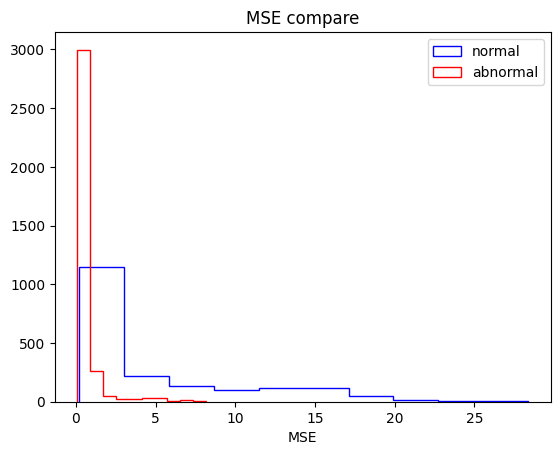

In [118]:
plt.title('MSE compare')
plt.hist(scored_train, bins=10, color='blue', histtype='step', label='normal')
plt.hist(scored_test, bins=10, color='red', histtype='step', label='abnormal')
plt.xlabel('MSE')
plt.legend()
plt.show()


In [119]:
print(error_df['true_class'].value_counts())


true_class
1.0    2190
0.0    1261
Name: count, dtype: int64


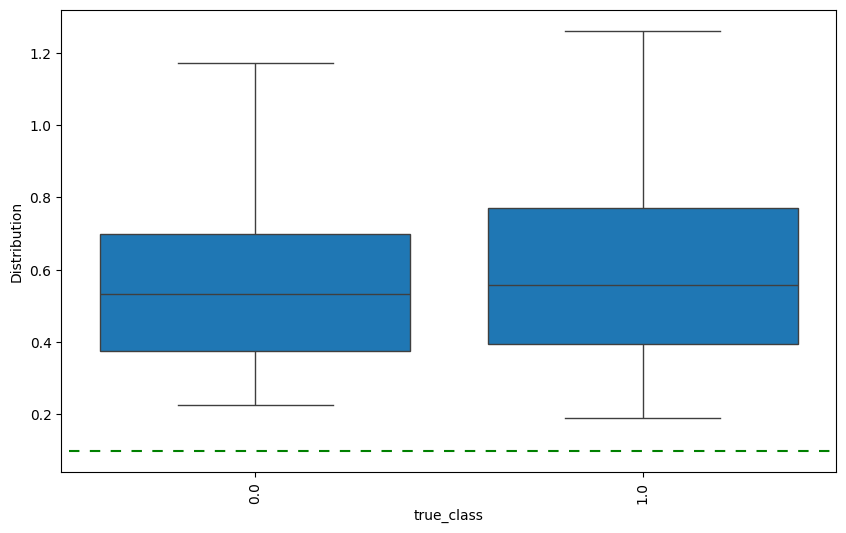

In [120]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df, showfliers=False, saturation=1)
plt.ylabel('Distribution')
plt.axhline(y=0.1, xmin=0.01, xmax=1, dashes=(5,5), c='g')
plt.xticks(rotation=90)
plt.show()


In [137]:
threshold = 0.4

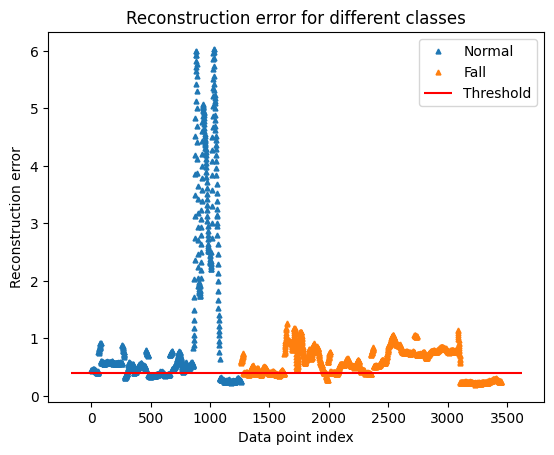

In [138]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label="Normal" if name == 0 else "Fall")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

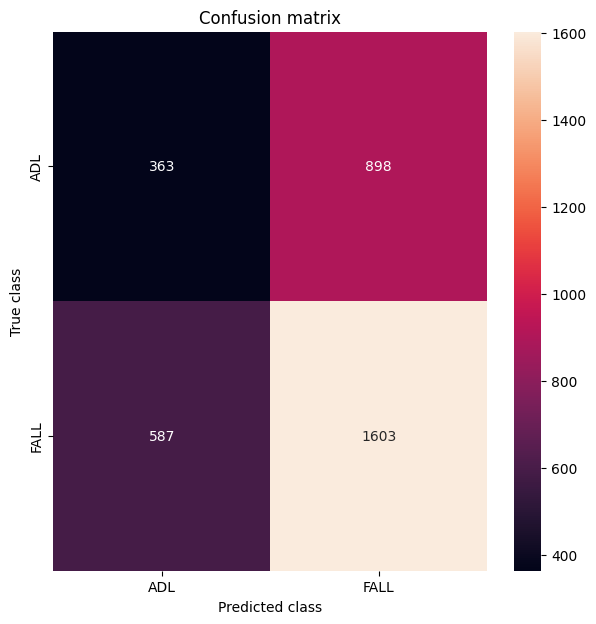

In [139]:
LABELS = ["ADL", "FALL"]
plt.figure(figsize=(7, 7))
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [140]:
print("\nClassification Report:")
print(classification_report(test_labels, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.38      0.29      0.33      1261
         1.0       0.64      0.73      0.68      2190

    accuracy                           0.57      3451
   macro avg       0.51      0.51      0.51      3451
weighted avg       0.55      0.57      0.55      3451

